#Uso de series difusas para el desarrollo de modelos de predicción de demandas de la energía eléctrica.

**Estudiante: José Manuel Rubio Cienfuegos.**

**Prof. José Miguel Rubio León.**

**Prof coguía: Francisco Rivera.**

El siguiente notebook contiene todo el código usado para el desarrollo de modelos difusos, junto con otros regresores para comparar el rendimiento de estos modelos con otros provenientes del estado del arte 

##Librerías

Esta celda contiene información sobre todas librerías necesarias para el procesamiento de la información y exposición de los resultados obtenidos.

In [ ]:
# Procesamiento de datos y gráficos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos de ML clásicos.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm

# Métricas
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error

# Pickle para el guardaddo de variables pesadas.
import pickle

# MAPE Function

def MAPE(y_true, y_pred):
  true_length, pred_length = y_true.__len__(), y_pred.__len__()
  assert true_length == pred_length, ('Lengths of arrays are differents, y_true have ' + str(true_length) + ' values and y_pred have ' + str(pred_length) + ' values.')
  return (100*(sum(abs((y_true - y_pred)/(y_true)))))/(y_true.__len__())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/JossRubio/Prediccion_demanda_energetica

Cloning into 'Prediccion_demanda_energetica'...
remote: Enumerating objects: 110, done.
remote: Total 110 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (110/110), 18.02 MiB | 25.67 MiB/s, done.
Resolving deltas: 100% (38/38), done.


##Carga de datos

Los datos a utilizar se cargan en este bloque. Previo a esto se deben haber subido a la interfaz de colab o habilitar un link de algun servidor para cargarlos de manera remota. En el siguiente bloque se pueden subir los archivos de forma local

Con los archivos subidos, entonces se cargan dentro del notebook

In [ ]:
# Extracción de datasets

directory = "Prediccion_demanda_energetica/data/"                   # Directorio donde se almacenan los datasets.
directory_var = 'Prediccion_demanda_energetica/codes/variables/'    # Directorio donde se almacenan las variables de interes.

df_energy = pd.read_csv(directory + "energy_dataset.csv")

df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


Antes de desarrollar algun modelo, se debe destacar que dentro de los datos ya se cuentan con valores predichos para la demanda. Por ello esta celda indica cual es el **MAPE** (*Mean Absolute Percentage Error*) de los datos pronosticados guardados en el dataset *energy_dataset.csv*

In [ ]:
df_demand = df_energy[['total load actual', 'total load forecast']].dropna() # Eliminación de nans presentes en la columna de valores de la demanda.
demand_total, demand_forecast = df_demand['total load actual'], df_demand['total load forecast']

# MAPE de los valores predichos en la demanda del dataset original.
MAPE_goal = MAPE(demand_total.values, demand_forecast.values)
print('The MAPE of the work is:', round(MAPE_goal, 3), '%') 

The MAPE of the work is: 1.096 %


In [ ]:
df_energy.shape

(35064, 29)

##Preprocesamiento de datos de demanda de energía eléctrica

In [ ]:
def nans_remove(df, nan_threshold, reset_index=True):
  df_process = df.copy()
  assert nan_threshold < 1 and nan_threshold > 0 , ('nan threshold must be between 0 and 1')
  cols_names = df.columns
  for name in cols_names:
    len, drop_len = df_process[name].__len__(), df_process[name].dropna().__len__()
    difference_reason = (len - drop_len)/(len)
    if difference_reason > (1-nan_threshold):
      df_process.drop(columns=[name], inplace=True)
    else:
      continue
  df_process.dropna(inplace=True)
  df_process.reset_index(drop=reset_index, inplace=reset_index)
  return df_process

nan_limit = .9

# Eliminando las columnas nans del dataframe se tiene.
columns_interest = ['time','total load actual', 'total load forecast']
df_energy_processed = nans_remove(df_energy[columns_interest], nan_limit)

## Series Temporales Difusas.

Mediante la representación mostrada en la sección anterior, en esta sección se añade las características de los conjuntos difusos para la obtención de nuevas representaciones de la información de la demanda de la energía.

In [ ]:
# Instalación de la librería pyFts, para poder utilizar series temporales difusas.

!pip3 install -U git+https://github.com/PYFTS/pyFTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-9p32ollc
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-9p32ollc
  Created wheel for pyFTS: filename=pyFTS-1.6-py3-none-any.whl size=217208 sha256=d260b437a18fddde9ece43851a5a3822d87f57b540f1a74a1c2daba17e56870d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sc4kaoag/wheels/30/23/2b/2e10c811e284f08e37b5f6d6320e78bade4dd580081288f61a
Successfully built pyFTS


In [ ]:
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.common import Membership as mf
from pyFTS.benchmarks import benchmarks as bchmk

### Caso con data de energía.

In [ ]:
demand_data = df_energy_processed.drop(columns=['total load forecast'], axis=1)
demand_values = demand_data['total load actual'].values

# Creando los datasets de entrenamiento y prueba.
train_size = .7
train_length = int(train_size*demand_data.__len__())

# Conjuntos para análisis inicial.
train_values, test_values = demand_values[:train_length], demand_values[train_length:]
train_df, test_df = demand_data.iloc[:train_length], demand_data.iloc[train_length:]

In [ ]:
print(train_values.shape)
print(test_values.shape)

(24519,)
(10509,)


Ploteo de parte de las series

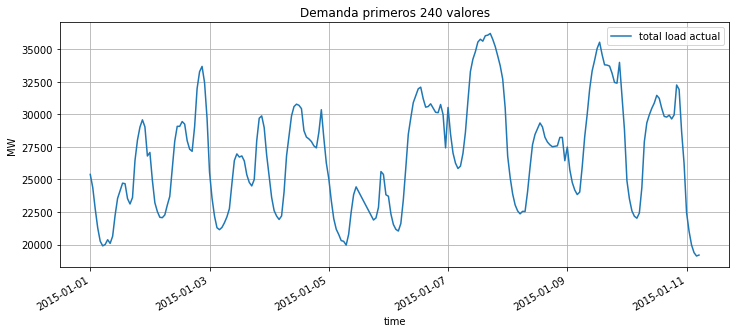

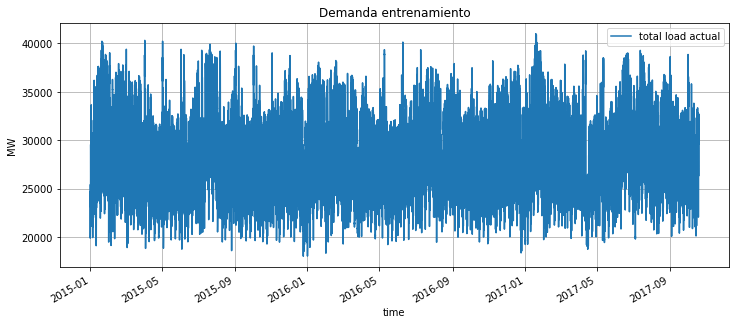

In [ ]:
train_df.iloc[:240].plot(x="time", figsize=(12,5), title="Demanda primeros 240 valores", ylabel="MW", grid=True)
train_df.plot(x="time", figsize=(12,5), title="Demanda entrenamiento", ylabel="MW", grid=True)

###Configuración del tipo de partición.

En estas celdas se configura el tipo de partición que se realiza a la data, se pueden cambiar entre 3 tipos de particiones.

#### Nombres de los niveles de partición

In [ ]:
from itertools import product

levels = ['VL','L','M','H','VH']    # Nombres de los niveles que se le aplicara a las particiones
q_levels = 7                        # Cantidad de subniveles.

# Creación de los nombres de las particiones junto con sus subniveles
sublevels = [str(k) for k in np.arange(0,q_levels)]
names = []
for combination in product(*[levels, sublevels]):
  names.append(combination[0]+combination[1])
  
print(names)

['VL0', 'VL1', 'VL2', 'VL3', 'VL4', 'VL5', 'VL6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'VH0', 'VH1', 'VH2', 'VH3', 'VH4', 'VH5', 'VH6']


#### Tipo de Partición

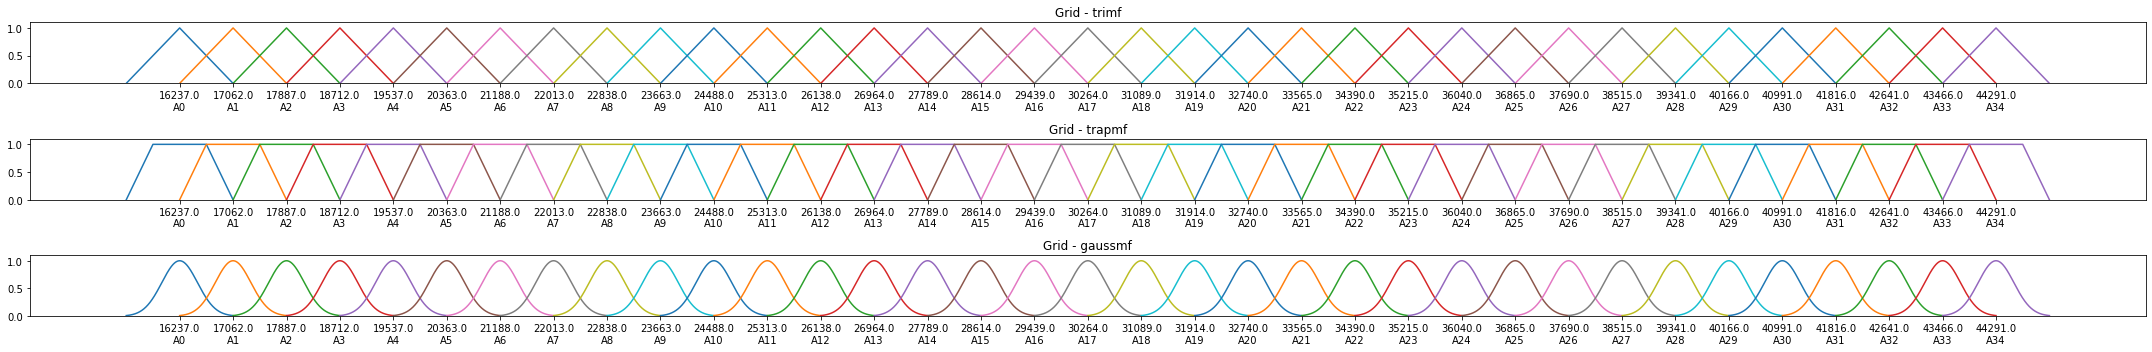

In [ ]:
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.common import Membership as mf
from pyFTS.benchmarks import benchmarks as bchmk

# Se configura el GridParitioner con 3 tipos de particiones, triangular, trapezoide y gaussiana.

partitions = pUtil.explore_partitioners(data=train_values, npart=35, methods=[Grid.GridPartitioner],
                                       mf=[mf.trimf, mf.trapmf, mf.gaussmf], size=[30,5], save=True, file='partitions_types.png')

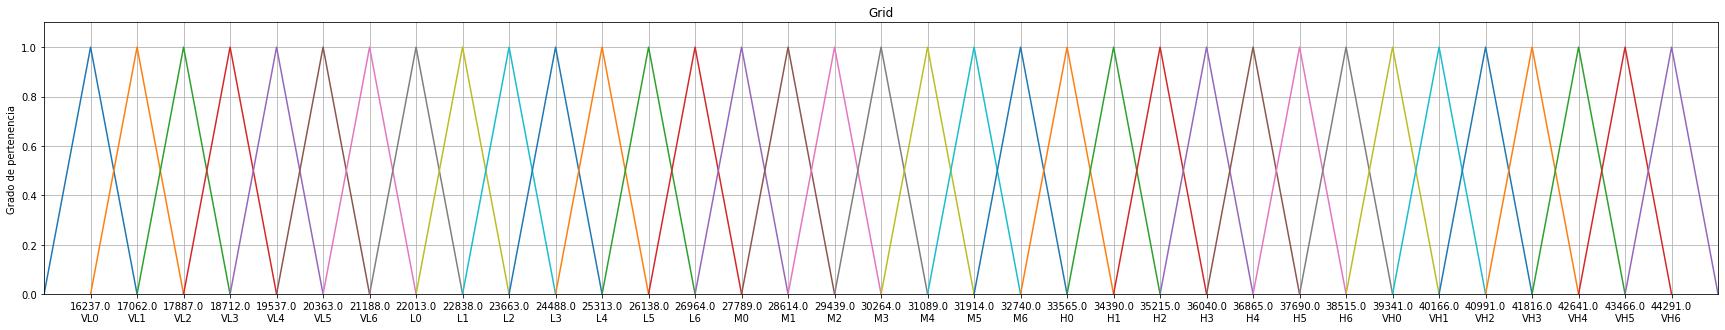

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[30,5])

part = Grid.GridPartitioner(data=train_values,npart=35, mf=mf.gaussmf, names=names)
# part.membership_function = mf.gaussmf

# part = partitions[0]

part.plot(ax)
plt.ylabel('Grado de pertenencia')
plt.grid(True)
# plt.savefig('partition1.png')

### Entrenamiento de modelos monovariables y multivariables

Seleccionando la partición de los conjuntos, entonces se realiza el entrenamiento de los modelos en las siguientes celdas, cuyos resultados de predicción son guardados en un dataframe.

In [ ]:
# Modelos de una sola variable.
from pyFTS.models import hofts, pwfts
from pyFTS.common import Util

# Métricas para el rendimiento de modelos
from pyFTS.benchmarks import Measures

#### Sistema de entrenamiento para series temporales difusas.

El entrenamiento de sistemas monovariables y multivariables es muy similar, por ende se realiza el desarrollo del siguiente objeto para 

In [ ]:
class FuzzyTrainer():

  """ 
  Inicializador del objeto.

    data: (pd.DataFrame) Dataframe que contiene los datos a procesar.
    train_size: (float) Valor decimal que contiene el porcentaje de datos que se desea utilizar al realizar el entrenamiento del modelo.
    partition_type: (pyFTS.partitioners) tipo de partición que se le desea aplicar a la data.
    variables_list : (list) Lista que contiene las variables a añadir en caso de que se desee realizar un entrenamiento de la 
                            serie con mas de una variable.

  """

  def __init__(self, data, target, train_size, partition_type=Grid.GridPartitioner, variables_list=[]):
    self.data = data
    self.partition_type = partition_type
    self.variables_list = variables_list
    train_length = int(data.__len__() * train_size)

    # Separando los datos del conjunto de entrenamiento y prueba dependiendo del tipo de modelo que se utilice
    if variables_list.__len__() == 0:
      data_values = data[target].values
      self.train_data = data_values[:train_length]
      self.test_data = data_values[train_length:]
    else:
      self.train_data = data.iloc[:train_length]
      self.test_data = data.iloc[train_length:]


  """ 
  fit_single. Este metodo se usa para entrenar modelos que solo posean una sola variable.

    model: (pyFTS.models) modelo de pyFTS que se desea entrenar. Este ya debe venir inicializado
    save_local: (bool) Valor booleano que indica si se desea guardar el modelo.
    
  """
  def fit_single(self, model, order, save_local=True):

    model = model(partitioner = self.partition_type, order=order)
    model.shortname += str(order)

    
    model.fit(self.train_data)

    if save_local:
      Util.persist_obj(model, model.shortname)
    else:
      pass
    self.model = model
    self.order = order

  """ 
  fit_multi. Si se tiene un regresor difuso multivariable, entonces se debe utilizar este metodo para realizar el entrenamiento del modelo

    model: (pyFTS.models) modelo de pyFTS que se desea entrenar, este ya debe venir inicializado.
    target_variable (pyFTS.models.multivariate.variable) variable de interes que contiene los datos que se quieren analizar.
    save_local: (bool) Valor booleano que indica si se desea guardar el modelo.
  """
  def fit_multi(self, model, target_variable, save_local=True):
    for variable in self.variables_list:
      model.append_variable(variable)

    model.target_variable = target_variable
    model.fit(self.train_data)
    if save_local:
      Util.persist_obj(model, model.shortname)
    else:
      pass
    self.model = model


  def predict(self, data, dropna=False):
    predictions = list(self.model.predict(data))
    # if delete_model:
    #   del(self.model)
    if dropna or predictions.__len__() == self.test_data.__len__():
      return predictions
    else:
      k = 0
      delta_pred = self.test_data.__len__() - predictions.__len__()
      while k < delta_pred:
        predictions.insert(0, np.nan)
        k += 1
      return predictions

#### Modelos con variable única.

En las siguientes celdas se tienen diversos modelos que solo tienen en cuenta la variable de interes.

In [ ]:
models_single = [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]

# Inicializador del objeto de entrenamiento

data = demand_data
target = 'total load actual'
train_size = .7

generate_dict_single = False     # Decidiendo si se desea obtener el diccionario con las predicciones de los regresores con 1 variable
# partitions = [part]

In [ ]:
if generate_dict_single:

  # Tipos de particiones cargadas

  grid_types = ['gauss', 'trap', 'tri']
  predictions_single_dict = dict()    # Diccionario para guardar los dataframes con las predicciones segun el tipo de partición.
  # part = partition[2]

  # Variables para almacenar los datos obtenidos por los modelos

  for k, part in enumerate(partitions):
    partition_name = 'GridPartitioner_' + grid_types[k]
    print('Process Fuzzy regressor, one variable. partitioner: ' + partition_name)
    prediction_df = test_df.copy()
    fuzzy_single_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, partition_type=part)

    for method in models_single:
      for order in [1,2,3]:
        print('Order model: ', order)
        fuzzy_single_trainer.fit_single(model=method, order=order)
        prediction_df[fuzzy_single_trainer.model.shortname] = fuzzy_single_trainer.predict(test_values)

    predictions_single_dict[partition_name] = prediction_df
    print('Predictions saved!')
    print('--------------')
    del(prediction_df)
    del(fuzzy_single_trainer)

  pickle.dump(predictions_single_dict, open('predictions_single_dict.pickle', 'wb'))  # Guardando el diccionario generado.

else:
  predictions_single_dict = pickle.load(open(directory_var + 'predictions_single_dict.pickle', 'rb'))

In [ ]:
models_show = ['time', 'total load actual', 'PWFTS3', 'PWFTS2', 'PWFTS1']

In [ ]:
predictions_single_dict.keys()

dict_keys(['GridPartitioner_tri', 'GridPartitioner_trap', 'GridPartitioner_gauss'])

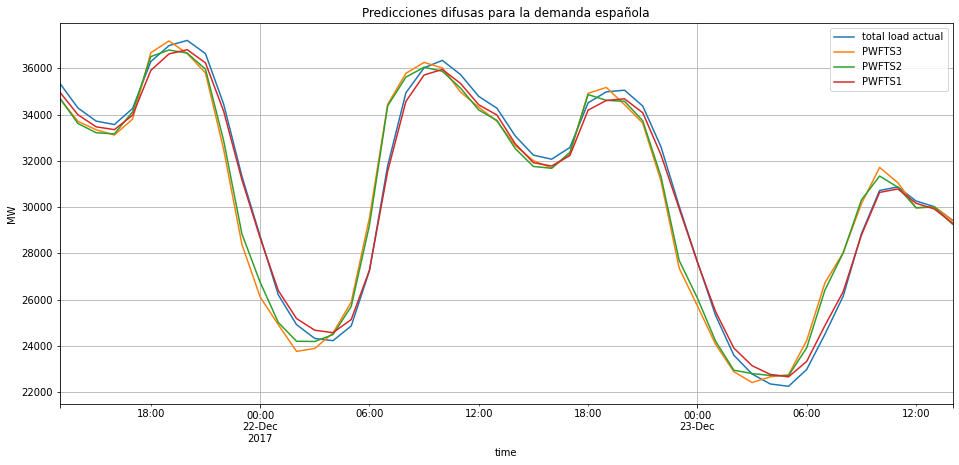

In [ ]:
pred_single_test = predictions_single_dict['GridPartitioner_tri']
pred_single_test[models_show].iloc[1500:1550].plot(x='time', ylabel='MW', title='Predicciones difusas para la demanda española', grid=True, figsize=(16,7))
# plt.savefig('PWFTS_results.png')

#### Modelos de varias variables

Se pueden incorporar diversas variables dentro del análisis al momento de realizar el entrenamiento de los regresores con series difusas

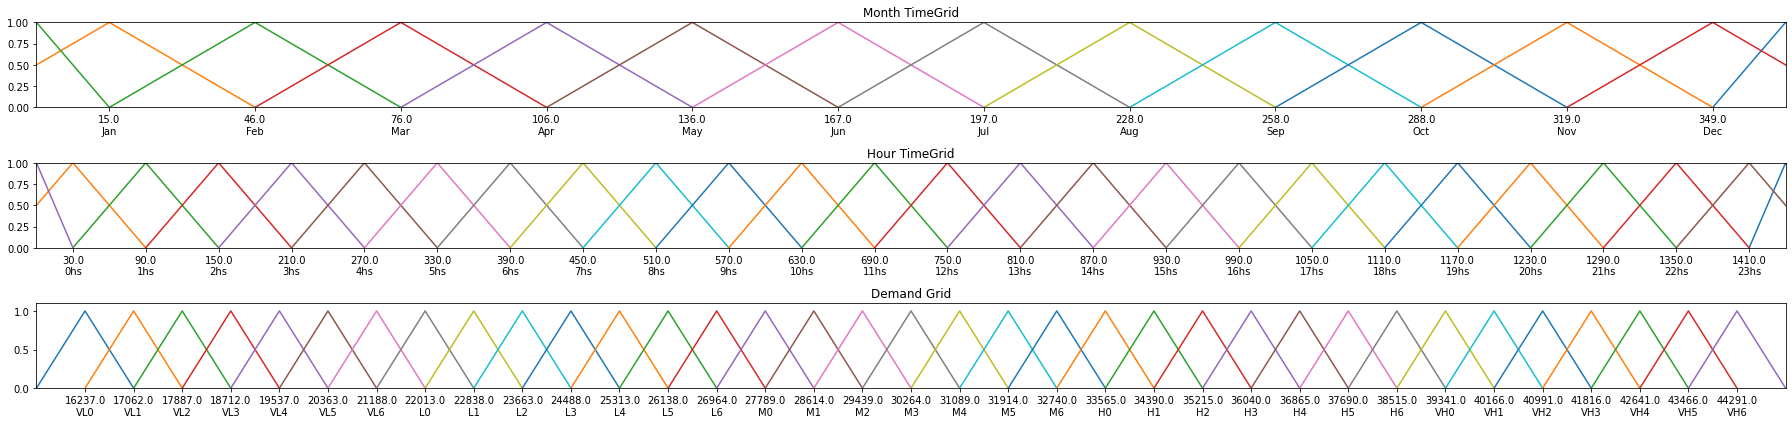

In [ ]:
from pyFTS.models.seasonal.common import DateTime
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[25,6])


# Partición del tiempo para añadirlas a los modelos.

train_df = train_df

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Feb','Mar','Apr','May',
                                                      'Jun','Jul', 'Aug','Sep','Oct',
                                                      'Nov','Dec']}

# Mes
vmonth = variable.Variable("Month", data_label="time", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train_df, partitioner_specific=sp)

vmonth.partitioner.plot(ax[0])


sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

# Hora
vhour = variable.Variable("Hour", data_label="time", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_df, partitioner_specific=sp) 

vhour.partitioner.plot(ax[1])

# Demanda
vavg = variable.Variable("Demand", data_label="total load actual", alias='dem',
                         partitioner=Grid.GridPartitioner, npart=35, partitioner_specific={'names': names},  
                         data=train_df) 

vavg.partitioner.plot(ax[2])

plt.tight_layout()
# plt.savefig('partition_time.png')

In [ ]:
from pyFTS.models.multivariate import mvfts, wmvfts, granular

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

generate_pred_multi_df = False    # Se decide si se desea entrenar el modelo.

if generate_pred_multi_df:
  parameters = [
      {},{},
      {'order':2, 'knn': 1},
      {'order':2, 'knn': 2},
      {'order':2, 'knn': 3},
  ]

  # Modelos que se desean utilizar.

  models_multi = [mvfts.MVFTS, wmvfts.WeightedMVFTS, granular.GranularWMVFTS,granular.GranularWMVFTS,granular.GranularWMVFTS]
  # models_multi = [granular.GranularWMVFTS, granular.GranularWMVFTS, granular.GranularWMVFTS]
  # models_multi = [granular.GranularWMVFTS]

  # Inicializador del objeto de entrenamiento

  data = demand_data
  target = 'total load actual'
  train_size = .7
  variables_list = [vmonth, vhour, vavg]

  fuzzy_multi_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, variables_list=variables_list)

  # Dataframe con los valores de las predicciones de los modelos multivariables
  predictions_multi_df = test_df.copy()

  # ax.plot(test_values[:100],label='demand')

  for ct, method in enumerate(models_multi):
    try:
      model = method(**parameters[ct])
      model.shortname += str(ct)
      print("Processing " + model.shortname)
      
      fuzzy_multi_trainer.fit_multi(model, vavg)
      predictions_multi_df[model.shortname] = fuzzy_multi_trainer.predict(test_df)
      del(model)

    except Exception as ex:
      print(key, method, parameters[ct])
      print(ex)

  predictions_multi_df.to_csv('predictions_multi_df.csv')   # Guardando el dataframe generado.

else:
  predictions_multi_df = pd.read_csv(directory_var + 'predictions_multi_df.csv', index_col='Unnamed: 0')
  predictions_multi_df['time'] = pd.to_datetime(predictions_multi_df['time'], format='%Y-%m-%d %H:%M:%S')
  

In [ ]:
multi_cols = ['time','total load actual','FIG-FTS2','FIG-FTS3','FIG-FTS4']

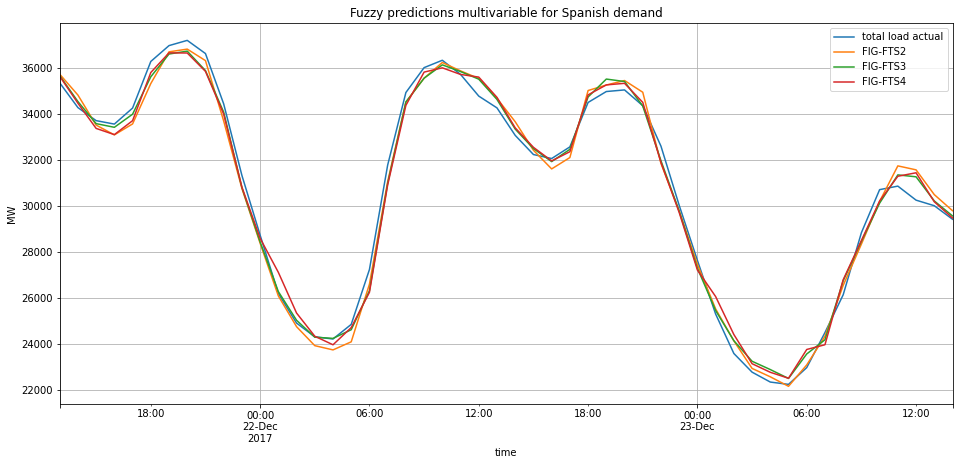

In [ ]:
predictions_multi_df[multi_cols].iloc[1500:1550].plot(x='time', ylabel='MW', title='Fuzzy predictions multivariable for Spanish demand', 
                                                grid=True, figsize=(16,7))

# plt.savefig('FIG-FTS_results.png')

### Rendimiento de los modelos obtenidos

Utilizando las métricas del RMSE y MAPE se Rankean los modelos experimentados. Para ello se utiliza la siguiente función.

In [ ]:
# Función para el cálculo de métricas de rendimiento de diversos modelos.

def regression_metrics(df, target_column, is_multivariate=False, partition_type='GridPartitioner'):
  y_true = df[target_column].values
  df_process = df.drop(columns=['time', target_column], axis=1)
  df_metrics = pd.DataFrame()
  df_metrics['model'] = df_process.columns
  rmse_list, mape_list = [], []
  for model in df_process.columns:
    forecast_values = df_process[model].values
    RMSE = Measures.rmse(y_true, forecast_values)
    MAPE = Measures.mape(y_true, forecast_values)
    rmse_list.append(RMSE)
    mape_list.append(MAPE)

  model_type = ['multi'] if is_multivariate else ['single']
  df_metrics['model_type'] = model_type * df_process.columns.__len__()
  df_metrics['data_partition'] = [partition_type] * df_process.columns.__len__()
  df_metrics['RMSE'] = rmse_list
  df_metrics['MAPE'] = mape_list

  return df_metrics

Aplicando la función anterior a las predicciones obtenidas anteriormente

In [ ]:
partitions_single = list(predictions_single_dict.keys())
default_df = df_energy_processed.loc[predictions_single_dict['GridPartitioner_tri'].index]


# Obteniendo los valores del rmse y mape de las predicciones que vinieron por default en el dataset.
default_rmse = round(Measures.rmse(default_df['total load actual'], default_df['total load forecast']), 3)
default_mape = Measures.mape(default_df['total load actual'], default_df['total load forecast'])
default_metrics = np.array(['work_model', '-', '-', default_rmse, default_mape]).reshape(1,5)

# Inicializando el dataframe con los valores anteriores.
metrics_single_df = pd.DataFrame(default_metrics, columns=['model', 'model_type', 'data_partition', 'RMSE', 'MAPE'])

for part_name in partitions_single:
  prediction_df = predictions_single_dict[part_name]
  metrics_df = regression_metrics(prediction_df.dropna(), 'total load actual', partition_type=part_name)
  metrics_single_df = pd.concat([metrics_single_df, metrics_df], axis=0)

# Como los primeros valores fueron una lista variada, entonces se debe cambiar el tipo de dato presente en la columna MAPE.
metrics_single_df = metrics_single_df.astype({'MAPE': float})
metrics_single_df.sort_values('MAPE').reset_index()

,index,model,model_type,data_partition,RMSE,MAPE
0,6,PWFTS1,single,GridPartitioner_tri,279.343232,0.873689
1,6,PWFTS1,single,GridPartitioner_gauss,285.091868,0.878171
2,6,PWFTS1,single,GridPartitioner_trap,288.237234,0.884289
3,0,work_model,-,-,399.606,0.958811
4,5,WHOFTS3,single,GridPartitioner_tri,926.749189,2.336246
5,5,WHOFTS3,single,GridPartitioner_trap,926.749189,2.336246
6,7,PWFTS2,single,GridPartitioner_trap,908.999665,2.392339
7,7,PWFTS2,single,GridPartitioner_tri,944.609807,2.467142
8,4,WHOFTS2,single,GridPartitioner_tri,989.391383,2.540643
9,4,WHOFTS2,single,GridPartitioner_trap,989.391383,2.540643


In [ ]:
multi_metrics = regression_metrics(predictions_multi_df.dropna(), 'total load actual', is_multivariate=True)
multi_metrics.sort_values('MAPE')

,model,model_type,data_partition,RMSE,MAPE
3,FIG-FTS3,multi,GridPartitioner,657.091708,1.541361
4,FIG-FTS4,multi,GridPartitioner,669.663047,1.584120
2,FIG-FTS2,multi,GridPartitioner,708.383152,1.709964
1,WeightedMVFTS1,multi,GridPartitioner,1258.165064,3.480405
0,MVFTS0,multi,GridPartitioner,1303.604255,3.603796


In [ ]:
multi_metrics = regression_metrics(predictions_multi_df.dropna(), 'total load actual', is_multivariate=True)
multi_metrics.sort_values('MAPE')

,model,model_type,data_partition,RMSE,MAPE
3,FIG-FTS3,multi,GridPartitioner,657.091708,1.541361
4,FIG-FTS4,multi,GridPartitioner,669.663047,1.584120
2,FIG-FTS2,multi,GridPartitioner,708.383152,1.709964
1,WeightedMVFTS1,multi,GridPartitioner,1258.165064,3.480405
0,MVFTS0,multi,GridPartitioner,1303.604255,3.603796


In [ ]:
# Concatenando las metricas obtenidas para ambos tipos de modelos

grid_metrics = pd.concat([metrics_single_df, multi_metrics], axis=0)
metrics_final = grid_metrics.sort_values('MAPE')
metrics_final.reset_index(drop=True, inplace=True)
metrics_final

,model,model_type,data_partition,RMSE,MAPE
0,PWFTS1,single,GridPartitioner_tri,279.343232,0.873689
1,PWFTS1,single,GridPartitioner_gauss,285.091868,0.878171
2,PWFTS1,single,GridPartitioner_trap,288.237234,0.884289
3,work_model,-,-,399.606,0.958811
4,FIG-FTS3,multi,GridPartitioner,657.091708,1.541361
5,FIG-FTS4,multi,GridPartitioner,669.663047,1.584120
6,FIG-FTS2,multi,GridPartitioner,708.383152,1.709964
7,WHOFTS3,single,GridPartitioner_tri,926.749189,2.336246
8,WHOFTS3,single,GridPartitioner_trap,926.749189,2.336246
9,PWFTS2,single,GridPartitioner_trap,908.999665,2.392339


## Replicación de modelos del estado del arte.

En esta sección de muestran una adaptación de una serie de modelos de estado del arte para la predicción de demanda de energía eléctrica. En primer lugar se realizara un pequeño preprocesamiento de datos.

### Modelos de machine learning supervisado

En esta sección se procesa la información de la base de datos para realizar las predicciones mediante el uso de series temporales clásicas.

In [ ]:
# Función para la generación de series temporales, cuyo largo se puede configurar.

def series_constructor(df, len_serie, column_serie, n_data, column_concat_name=None, dropna=True, reset_index=True):
  df_process = df[column_serie]
  df_out = pd.DataFrame() if column_concat_name == None else df[column_concat_name]
  for k in reversed(range(len_serie + 1)):
    serie_moved = df_process.shift(k)
    serie_moved.name = 't-' + str(k)
    df_out = pd.concat([df_out, serie_moved], axis=1)
  df_out.rename(columns={'t-0':'t'}, inplace=True)
  columns_final = list(df_out.columns) if column_concat_name == None else list(df_out.columns)[1:] + [column_concat_name]
  df_out = df_out[columns_final]
  df_out.dropna(inplace=dropna)
  df_out = df_out.iloc[:n_data]
  df_out.reset_index(drop=reset_index, inplace=reset_index)
  return df_out

In [ ]:
# Procesamiento de la información de la demanda con la función anterior

length_serie = 72       # Como la serie temporal corresponde a la demanda horaria, entonces el largo será 24.
n_data = df_energy_processed.__len__()

demand_time_series = series_constructor(df_energy_processed, length_serie, n_data=n_data, column_serie='total load actual', column_concat_name='time')  # Aplicando la función anterior.

demand_series, data_time = demand_time_series.drop(['time'], axis=1), demand_time_series['time']  # Separando la información en las series y datos del tiempo.

# Dataframes para el procesamiento de datos

X_data, y_data = demand_series.drop(['t'], axis=1), demand_series['t']

### Entrenamientos y tuneo de modelos ML supervisado.

Tras el preprocesamiento anterior, en este bloque se realiza el entrenamiento de la red neuronal y random forest tuneando algunos de sus hiperparámetros.

In [ ]:
from sklearn.model_selection import GridSearchCV

ml_train = False

if ml_train:

  # Separación de datos en conjuntos de entrenamiento y validación.
  train_size = .7

  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_size, shuffle=False)

  # Configuración de variables para el tuneo de los sistemas de ML supervisado.
  mlp_parameters = {'hidden_layer_sizes':[8,50,100], 'activation':('relu','logistic')}
  rf_parameters = {'n_estimators':[80,100,150]}

  # Configuración de regresores (sin tuneo) Red Neuronal y Random Forest.
  mlp_regressor = MLPRegressor()
  rf_regressor = RandomForestRegressor()

  # Configurando los hiperparametros junto con los regresor para realizar la búsqueda de la mejor configuración
  mlp_grid = GridSearchCV(mlp_regressor, mlp_parameters, verbose=2, cv=3)
  rf_grid = GridSearchCV(rf_regressor, rf_parameters, verbose=2, cv=3)

  # Entrenamiento de los modelos clásicos
  mlp_grid.fit(X_train, y_train)

  print('MLP fitted!')

  rf_grid.fit(X_train, y_train)

  print(mlp_grid.best_params_)
  print(rf_grid.best_params_)
  # Calculo de predicciones y resultados obtenidos por MAPE.
  mlp_predictions = mlp_grid.predict(X_test)
  rf_predictions = rf_grid.predict(X_test)

  # Predicciones ARIMA
  # arima_predictions = arima_fit.predict(start=ARIMA_train.__len__()+1, end=ARIMA_data.__len__(), dynamic=True)

  predictions_array = np.c_[mlp_predictions, rf_predictions]

  # Añadiendo las fechas de los resultados obtenidos
  index_test = y_test.index

  # Creando un DataFrame con los datos de las predicciones realizadas por los regresores
  predictions_df = pd.DataFrame(data=predictions_array, columns=['mlp_pred','rf_pred'], index=index_test)


  predictions_dates = pd.concat([data_time.iloc[index_test], predictions_df], axis=1)

  # Realizando un join con los datos forecast del dataset original.
  df_ml_predictions = pd.merge(predictions_dates, df_energy_processed, on='time')
  df_ml_predictions.index = index_test

  df_ml_predictions.to_csv('ml_predictions.csv', index=False)

else:
  df_ml_predictions = pd.read_csv(directory_var + 'ml_predictions.csv')
  df_ml_predictions['time'] = pd.to_datetime(df_ml_predictions['time'], format='%Y-%m-%d %H:%M:%S')

###Comparación de resultados

Los datos originales poseen predicciones ya realizadas anteriormente, por ende en esta celda se tiene una comparación de estas predicciones vs los resultados obtenidos por los modelos tradicionales de ML.

In [ ]:
# Printeando los valores MAPE para cada predicción obtenida.

data_real = df_ml_predictions['total load actual']
MLP_pred = df_ml_predictions['mlp_pred']
RF_pred = df_ml_predictions['rf_pred']
default_pred = df_ml_predictions['total load forecast']

print('MLP Error:', round(MAPE(data_real, MLP_pred), 3))
print('RF Error:', round(MAPE(data_real, RF_pred), 3))
print('Work Error:', round(MAPE(data_real, default_pred), 3))

MLP Error: 1.926
RF Error: 1.067
Work Error: 0.959


In [ ]:
ML_prediction_df = df_ml_predictions[['time', 'total load actual', 'mlp_pred', 'rf_pred', 'total load forecast']]

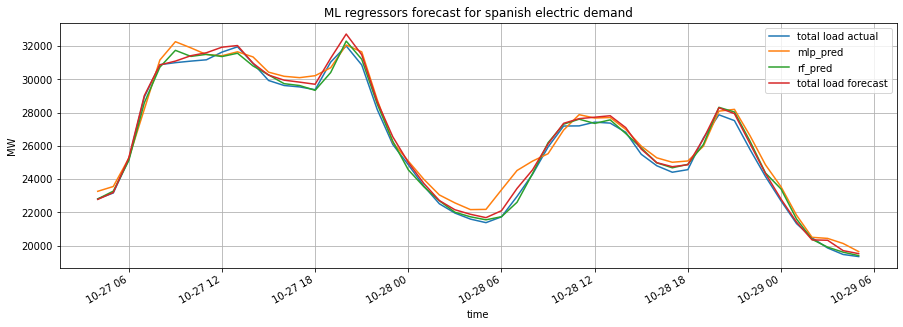

In [ ]:
ML_prediction_df.iloc[150:200].plot(x='time', ylabel='MW', title='ML regressors forecast for spanish electric demand', grid=True, figsize=(15,5))
# plt.savefig('ML_results.png')

##Transformer Adaptado

Este modelo de deep learning esta inspirado en la arquitectura del Transformer, presente en el paper *Attention is all you need*, donde este realiza trabajos de procesamiento de secuencias mediante el uso de sistemas de atención.

In [ ]:
!pip install helpers

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

import logging
import os, shutil
import argparse
import datetime
import torch, math, random
import torch.nn as nn

from joblib import load
from joblib import dump

### Modelo

In [ ]:
"""
Arquitectura basada en el modelo de transformer propuesto en el paper 'Attention is all you need' 
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, y Illia Polosukhin. 2017.
"""

class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size, n_heads, dim_ff_enc, num_layers, dropout=0):
        super(Transformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=n_heads, dim_feedforward=dim_ff_enc, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src,mask)
        output = self.decoder(output)
        return output

### Función de positional enconding

La función definida incorpora valores posicionales a la data de demanda horaria, permitiendo el proceso a los modulos de atención.

In [ ]:
def df_date_encoding(df):

    df_process = df.copy()
    timestamps = df_process['time']
    timestamps_hour = np.array([t.hour for t in timestamps])
    timestamps_day = np.array([t.day for t in timestamps])
    timestamps_month = np.array([t.month for t in timestamps])
 
    hours_in_day = 24
    days_in_month = 30
    month_in_year = 12

    df_process['sin_hour'] = np.sin(2*np.pi*timestamps_hour/hours_in_day)
    df_process['cos_hour'] = np.cos(2*np.pi*timestamps_hour/hours_in_day)
    df_process['sin_day'] = np.sin(2*np.pi*timestamps_day/days_in_month)
    df_process['cos_day'] = np.cos(2*np.pi*timestamps_day/days_in_month)
    df_process['sin_month'] = np.sin(2*np.pi*timestamps_month/month_in_year)
    df_process['cos_month'] = np.cos(2*np.pi*timestamps_month/month_in_year)

    return df_process

### Configuración del Demand Dataset.

Objeto que configura la carga y las características con las que debe ser procesado los datos de demanda energética

In [ ]:
class DemandDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, training_length, forecast_window, scale=True, n_reset=1):
        
        self.df = df_date_encoding(df)
        self.transform = MinMaxScaler()
        self.n = n_reset
        self.T = training_length
        self.S = forecast_window
        self.scale = scale

    def __len__(self):
        return self.n

    # Will pull an index between 0 and __len__. 
    def __getitem__(self, idx):
        # print(self.T)
        start = np.random.randint(0, len(self.df) - self.T - self.S + 1)
        index_in = torch.tensor([i for i in range(start, start+self.T)])
        index_tar = torch.tensor([i for i in range(start + self.T, start + self.T + self.S)])

        features = ['total load actual', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month']
        _input = torch.tensor(self.df[features][start : start + self.T].values)
        target = torch.tensor(self.df[features][start + self.T : start + self.T + self.S].values)

        # scalar input/output of shape: [n_samples, n_features].
        scaler = self.transform

        scaler.fit(_input[:,0].unsqueeze(-1))
        _input[:,0] = torch.tensor(scaler.transform(_input[:,0].unsqueeze(-1)).squeeze(-1)) if self.scale else _input[:,0]
        target[:,0] = torch.tensor(scaler.transform(target[:,0].unsqueeze(-1)).squeeze(-1)) if self.scale else target[:,0]

        # save the scalar to be used later when inverse translating the data for plotting.
        if self.scale:
          dump(scaler, 'scalar_item.joblib')

        return index_in, index_tar, _input, target

###Función de entrenamiento

Este bloque contiene el entrenamiento del modelo, este puede ser utilizando un enfoque para desarrollar predicciones one step o para pronósiticos sobre ventanas extensas.

In [ ]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s %(message)s", datefmt="[%Y-%m-%d %H:%M:%S]")
logger = logging.getLogger(__name__)

def flip_from_probability(p):
    return True if random.random() < p else False

def train_transformer(dataloader, EPOCH, train_method, k, feature_size, n_heads, dim_ff_enc, encoder_layers, path_to_save_model,
                      path_to_save_loss, path_to_save_predictions, device, xlabel_train, ylabel_train, title_train):

    device = torch.device(device)

    model = Transformer(feature_size=feature_size, n_heads=n_heads, dim_ff_enc=dim_ff_enc, num_layers=encoder_layers).double().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200)
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')

    for epoch in range(EPOCH + 1):
        train_loss = 0

        ## TRAIN -- TEACHER FORCING
        model.train()
        for index_in, index_tar, _input, target in dataloader:
        
            # Shape of _input : [batch, input_length, feature]
            # Desired input for model: [input_length, batch, feature]

            optimizer.zero_grad()
            src = _input.permute(1,0,2).double().to(device)[:-1,:,:] # torch.Size([24, 1, 7])
            target = _input.permute(1,0,2).double().to(device)[1:,:,:] # src shifted by 1.
            # sampled_src = src[:1, :, :] #t0 torch.Size([1, 1, 7])

            if train_method == 'one_step':
                prediction = model(src, device)
                loss = criterion(prediction, target[:,:,0].unsqueeze(-1))
            
            elif train_method == 'sampling':
                sampled_src = src[:1, :, :] #t0 torch.Size([1, 1, 7])
                for i in range(len(target)-1):

                  prediction = model(sampled_src, device) # torch.Size([1xw, 1, 1])

                  if i < 24: # One day, enough data to make inferences about cycles
                      prob_true_val = True
                  else:
                      ## coin flip
                      v = k/(k+math.exp(epoch/k)) # probability of heads/tails depends on the epoch, evolves with time.
                      prob_true_val = flip_from_probability(v) # starts with over 95 % probability of true val for each flip in epoch 0.
                      ## if using true value as new value

                  if prob_true_val: # Using true value as next value
                      sampled_src = torch.cat((sampled_src.detach(), src[i+1, :, :].unsqueeze(0).detach()))
                  else: ## using prediction as new value
                      positional_encodings_new_val = src[i+1,:,1:].unsqueeze(0)
                      predicted_humidity = torch.cat((prediction[-1,:,:].unsqueeze(0), positional_encodings_new_val), dim=2)
                      sampled_src = torch.cat((sampled_src.detach(), predicted_humidity.detach()))
                
                loss = criterion(target[:-1,:,0].unsqueeze(-1), prediction)
            
            """To update model after each sequence"""

            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()

        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train_{epoch}.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_{epoch}.pth")
            min_train_loss = train_loss
            best_model = f"best_train_{epoch}.pth"


        length_plot = 200

        if epoch % 100 == 0 and train_method == 'one_step': # Plot 1-Step Predictions

            logger.info(f"Epoch: {epoch}, Training loss: {train_loss}")
            scaler = load('scalar_item.joblib')
            src_init = scaler.inverse_transform(src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            prediction = scaler.inverse_transform(prediction[:,:,0].detach().cpu().numpy()) #torch.Size([35, 1, 7])
            src_to_plot, pred_to_plot = src_init[:length_plot], prediction[:length_plot]
            index_in_plot, index_tar_plot = index_in[:length_plot], index_tar[:length_plot]
            plot_training(epoch, path_to_save_predictions, src_to_plot, pred_to_plot, index_in, index_tar, xlabel_train, 
                            ylabel_train, title_train)

        if epoch % 10 == 0 and train_method == 'sampling': # Plot 1-Step Predictions

            logger.info(f"Epoch: {epoch}, Training loss: {train_loss}")
            scaler = load('scalar_item.joblib')
            sampled_src_humidity = scaler.inverse_transform(sampled_src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            src_init = scaler.inverse_transform(src[:,:,0].cpu()) #torch.Size([35, 1, 7])
            prediction = scaler.inverse_transform(prediction[:,:,0].detach().cpu().numpy()) #torch.Size([35, 1, 7])
            plot_training_3(epoch, path_to_save_predictions, src_init, sampled_src_humidity, prediction, index_in, index_tar,
                            xlabel_train, ylabel_train, title_train)

        train_loss /= len(dataloader)
        log_loss(train_loss, path_to_save_loss, train=True)
        
    plot_loss(path_to_save_loss, train=True)
    return best_model

### Funciones de visualizaciones gráficas

En este bloque se tienen diferentes funciones de visualización. Estas son aplicadas en las funciones definidas anteriormente, se pueden ver la función de costos durante el entrenamiento, las predicciones realizadas por el sistema cuando se encuentra en el entrenamiento y también cuando este ya finalizó.

In [ ]:
def plot_loss(path_to_save, train=True):
    plt.rcParams.update({'font.size': 10})
    with open(path_to_save + "/train_loss.txt", 'r') as f:
        loss_list = [float(line) for line in f.readlines()]
    if train:
        title = "Train"
    else:
        title = "Validation"
    EMA_loss = EMA(loss_list)

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 16})
    
    plt.plot(loss_list, label = "loss")
    plt.plot(EMA_loss, label="EMA loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title+"_loss")
    plt.grid(True)
    plt.savefig(path_to_save+f"/{title}.png")
    plt.close()

def plot_training(epoch, path_to_save, src, prediction, index_in, index_tar, xlabel, ylabel, title):

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)

    plt.title(title + ", Epoch " + str(epoch))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

def plot_training_3(epoch, path_to_save, src, sampled_src, prediction, index_in, index_tar, xlabel, ylabel, title):

    idx_scr = [i for i in range(len(src))]
    idx_pred = [i for i in range(1, len(prediction)+1)]
    idx_sampled_src = [i for i in range(len(sampled_src))]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    ## REMOVE DROPOUT FOR THIS PLOT TO APPEAR AS EXPECTED !! DROPOUT INTERFERES WITH HOW THE SAMPLED SOURCES ARE PLOTTED
    plt.plot(idx_sampled_src, sampled_src, 'o-.', color='red', label = 'sampled source', linewidth=1, markersize=10)
    plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)
    plt.title(title + " Epoch " + str(epoch))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(path_to_save+f"/Epoch_{str(epoch)}.png")
    plt.close()

###Funciones auxiliares

Sistemas de soporte para el uso de los bloques definidos anteriormente.

In [ ]:
# save train or validation loss
def log_loss(loss_val : float, path_to_save_loss : str, train : bool = True):
    if train:
        file_name = "train_loss.txt"
    else:
        file_name = "val_loss.txt"

    path_to_file = path_to_save_loss+file_name
    os.makedirs(os.path.dirname(path_to_file), exist_ok=True)
    with open(path_to_file, "a") as f:
        f.write(str(loss_val)+"\n")
        f.close()

# Exponential Moving Average, https://en.wikipedia.org/wiki/Moving_average
def EMA(values, alpha=0.1):
    ema_values = [values[0]]
    for idx, item in enumerate(values[1:]):
        ema_values.append(alpha*item + (1-alpha)*ema_values[idx])
    return ema_values

# Remove all files from previous executions and re-run the model.
def clean_directory(path_to_save_model, path_to_save_loss, path_to_save_predictions):

    if os.path.exists(path_to_save_loss):
        shutil.rmtree(path_to_save_loss)
    if os.path.exists(path_to_save_model): 
        shutil.rmtree(path_to_save_model)
    if os.path.exists(path_to_save_predictions): 
        shutil.rmtree(path_to_save_predictions)
    os.mkdir(path_to_save_loss)
    os.mkdir(path_to_save_model)
    os.mkdir(path_to_save_predictions)

### Main

Función principal que engloba los procesos anteriores vistos en esta sección, realiza el entrenamiento del sistema y guarda en la memoria la mejor configuración de parámetros obtenida, ademas de generar una gran cantidad de visualizaciones gráficas sobre el comportamiento del modelo durante el proceso de entrenamiento.

In [ ]:
def main(
    train_dataset,
    test_dataset,
    model_features,
    model_heads,
    model_dim_ff, 
    model_encoder_layers,
    train_method = 'one_step',
    epoch: int = 500,
    k: int = 60,
    batch_size: int = 1,
    training_length = 72,
    forecast_window = 24,
    path_to_save_model = "save_model/",
    path_to_save_loss = "save_loss/", 
    path_to_save_predictions = "save_predictions/", 
    device = "cpu",
    inference_rounds = 25,
    xlabel = "date",
    ylabel = "MW",
    title = "Predicciones de la demanda española usando transformers"
):

    clean_directory(path_to_save_model, path_to_save_loss, path_to_save_predictions)

    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    best_model = train_transformer(train_dataloader, epoch, train_method, k, model_features, model_heads, model_dim_ff, model_encoder_layers, 
                                   path_to_save_model,  path_to_save_loss, path_to_save_predictions, device, xlabel, ylabel, 
                                   title + " training.")
    
    return best_model

### Configuración de datos.

Se definen cuales seran los datos de entrenamiento y prueba a utilizar por este modelo.

In [ ]:
train_size = .7

train_values = int(df_energy_processed.__len__() * train_size)

df_energy_train = df_energy_processed.iloc[:train_values]
df_energy_test = df_energy_processed.iloc[train_values:]

torch.cuda.empty_cache()    # Liberando el cache de la GPU.

### Configuración del modelo y ejecución de entrenamiento

En este bloque se configuran los hiperparámetros del sistema y se ejecuta el entrenaiento con el uso de la función *main* definida previamente.

In [ ]:
# Model hyperparameters
n_heads = 7
encoder_layers = 3
dim_ff_enc = 2048

training_length = 2000
forecast_window = 48
device = "cuda"

epochs = 6000

train_dataset = DemandDataset(df=df_energy_train, training_length=training_length, forecast_window = forecast_window)
test_dataset = DemandDataset(df=df_energy_test, training_length=training_length, forecast_window = forecast_window)

feature_size = train_dataset.__getitem__(0)[2].size()[1]

In [ ]:
transf_train = False

if trans_train:
  best_model = main(train_dataset, test_dataset, model_features=feature_size, model_heads=n_heads, model_dim_ff=dim_ff_enc, 
                    model_encoder_layers=encoder_layers, epoch=epochs, training_length=training_length, forecast_window=forecast_window, 
                    device=device)

else:
  path_to_save_model = directory_var
  best_model = 'best_train_5719.pth'


[2022-04-04 09:25:37] [INFO] __main__ Epoch: 0, Training loss: 0.19601547782671214
[2022-04-04 09:25:59] [INFO] __main__ Epoch: 100, Training loss: 0.021404110137308374
[2022-04-04 09:26:20] [INFO] __main__ Epoch: 200, Training loss: 0.009190911705591295
[2022-04-04 09:26:42] [INFO] __main__ Epoch: 300, Training loss: 0.005400061572232575
[2022-04-04 09:27:03] [INFO] __main__ Epoch: 400, Training loss: 0.0047359525333178845
[2022-04-04 09:27:25] [INFO] __main__ Epoch: 500, Training loss: 0.003909897417885439
[2022-04-04 09:27:47] [INFO] __main__ Epoch: 600, Training loss: 0.0028021764495048456
[2022-04-04 09:28:08] [INFO] __main__ Epoch: 700, Training loss: 0.0017152126108713138
[2022-04-04 09:28:30] [INFO] __main__ Epoch: 800, Training loss: 0.004153829603493615
[2022-04-04 09:28:52] [INFO] __main__ Epoch: 900, Training loss: 0.001590767751236769
[2022-04-04 09:29:13] [INFO] __main__ Epoch: 1000, Training loss: 0.001917857199274278
[2022-04-04 09:29:35] [INFO] __main__ Epoch: 1100, Tr

### Función de inferencia para predicciones one step

Algoritmo que arroja predicciones one step tras el uso de un modelo de atención sobre una serie determinada.

In [ ]:
def inference_one_steps(df_with_time, model, device, process_length):

  scaler = load('scalar_item.joblib')
  df_process = df_date_encoding(df_with_time.copy())
  values_encoded = df_process.drop(['time','total load forecast'], axis=1).values
  values_encoded[:,0] = scaler.transform(values_encoded[:,0].reshape(-1,1))[:,0]

  output = np.array([])
  tensor_serie = torch.tensor(values_encoded, device=device).unsqueeze(1)
  i = 0
  while i < tensor_serie.__len__():
    model_input = tensor_serie[i:i+process_length,:,:]
    prediction = model(model_input, device)
    output = np.append(output, scaler.inverse_transform(prediction.cpu().detach().numpy().reshape(-1,1)).reshape(-1,))
    i += process_length

  return output

### Predicciones

En este bloque se obtienen las predicciones del *transformer adaptado* y se guardan los valores junto con la fecha en un dataframe.

In [ ]:
device = 'cpu'

model = Transformer(feature_size=feature_size, n_heads=n_heads, dim_ff_enc=dim_ff_enc, num_layers=encoder_layers).double().to(device)
model.load_state_dict(torch.load(path_to_save_model+best_model, map_location=torch.device(device)))

df_with_time = df_energy_test
process_length = training_length

predictions = inference_one_steps(df_with_time=df_with_time, model=model, device=device, process_length=process_length)

In [ ]:
true_values = df_energy_test.values[:,1][1:].astype(np.float64)
pred_values = predictions[:-1]

Measures.mape(true_values, pred_values)

1.3056246399549796

In [ ]:
df_transformer_results = df_energy_test[['time','total load actual','total load forecast']].iloc[1:]
df_transformer_results['transf_pred'] = pred_values

## Comparación de resultados

En esta sección se comparan todas las predicciones one step obtenidas en este trabajo a traves del análisis de todas las predicciones guardadas en los dataframes.

### Union de dataframes de predicciones

En este bloque se juntan las predicciones de todos los modelos probados.

In [ ]:
df_fuzzy_single = predictions_single_dict['GridPartitioner_tri'].drop(['total load actual'], axis=1).dropna()
df_fuzzy_multi = predictions_multi_df.drop(['total load actual'], axis=1).dropna()
df_ml_predictions_to_merge = df_ml_predictions.drop(['total load actual','total load forecast'], axis=1)

df_predictions = pd.merge(df_fuzzy_single, df_fuzzy_multi, on='time')
df_predictions = pd.merge(df_predictions, df_ml_predictions_to_merge, on='time')
df_predictions = pd.merge(df_predictions, df_transformer_results, on='time')
df_predictions.rename(columns={'total load forecast':'TSO forecast'}, inplace=True)

###Función de cálculo de rendimientos

Para obtener el rendimiento de los modelos, se diseño esta función que calcula el MAPE y RMSE 

In [ ]:
def regression_evaluation(df, target_column):
  y_true = df[target_column].values
  df_process = df.drop(columns=['time', target_column], axis=1)
  df_metrics = pd.DataFrame()
  df_metrics['model'] = df_process.columns
  rmse_list, mape_list = [], []
  for model in df_process.columns:
    forecast_values = df_process[model].values
    RMSE = Measures.rmse(y_true, forecast_values)
    MAPE = Measures.mape(y_true, forecast_values)
    rmse_list.append(RMSE)
    mape_list.append(MAPE)

  df_metrics['RMSE'] = rmse_list
  df_metrics['MAPE'] = mape_list

  return df_metrics

In [ ]:
df_model_metrics = regression_evaluation(df_predictions, 'total load actual').sort_values('MAPE').reset_index(drop=True)
df_model_metrics

,model,RMSE,MAPE
0,PWFTS1,279.450140,0.874062
1,TSO forecast,399.792718,0.958921
2,rf_pred,509.006494,1.066645
3,transf_pred,551.534168,1.298334
4,FIG-FTS3,657.579560,1.542602
5,FIG-FTS4,670.177691,1.585647
6,FIG-FTS2,708.768554,1.710961
7,mlp_pred,749.224370,1.925658
8,WHOFTS3,926.852540,2.336132
9,PWFTS2,944.954885,2.468389


###Función de visualización gráfica

In [ ]:
def visual_predictions(df, columns_to_plot, filename_save, xlabel, ylabel, title):

    dates = df['time'].values

    # idx_scr = [i for i in range(len(src))]
    # idx_pred = [i for i in range(1, len(prediction)+1)]

    idx_scr = [t for t in dates]

    plt.figure(figsize=(15,6))
    plt.rcParams.update({"font.size" : 18})
    plt.grid(b=True, which='major', linestyle = '-')
    plt.grid(b=True, which='minor', linestyle = '--', alpha=0.5)
    plt.minorticks_on()

    colors = ['blue', 'darkorange', 'red', 'limegreen', 'yellow', 'aquamarine', 'darkcyan', 'fuschia', 'darkviolet', 'midnightbue', 
              'slategreey']

    for k, column in enumerate(columns_to_plot):
      data_to_plot = df[column].values
      plt.plot(idx_scr, data_to_plot, 'o-', color=colors[k], label=column, linewidth=1)
    # plt.plot(idx_scr, src, 'o-.', color = 'blue', label = 'input sequence', linewidth=1)
    # plt.plot(idx_pred, prediction, 'o-.', color = 'limegreen', label = 'prediction sequence', linewidth=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    plt.savefig(filename_save)
    plt.close()

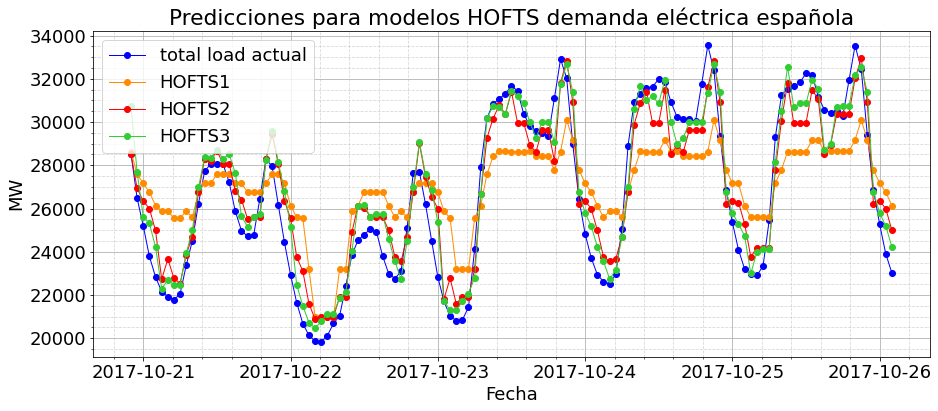

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'HOFTS1', 'HOFTS2', 'HOFTS3']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='HOFTS_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones para modelos HOFTS demanda eléctrica española')

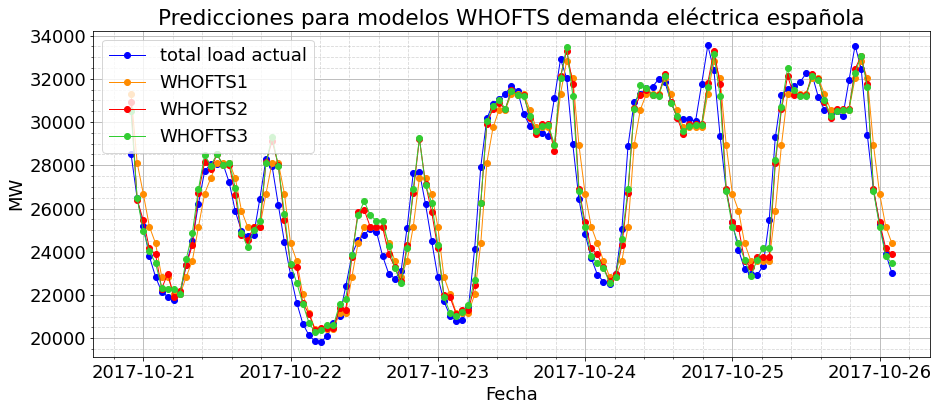

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'WHOFTS1', 'WHOFTS2', 'WHOFTS3']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='WHOFTS_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones para modelos WHOFTS demanda eléctrica española')

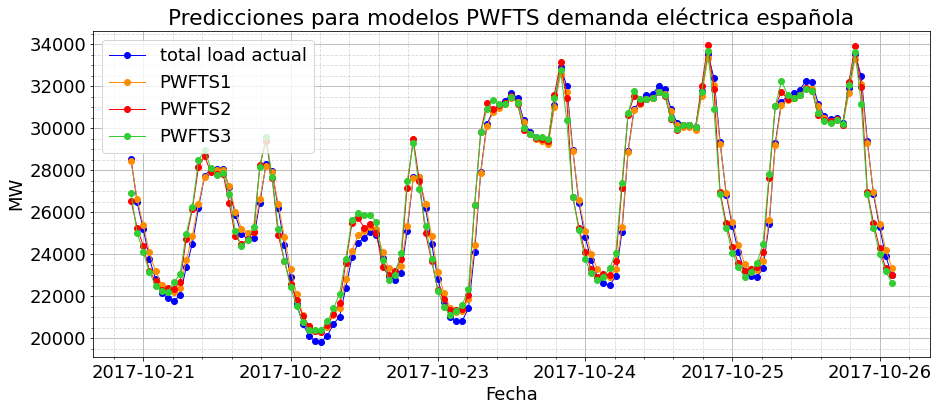

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'PWFTS1', 'PWFTS2', 'PWFTS3']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='PWFTS_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones para modelos PWFTS demanda eléctrica española')

In [ ]:
df_predictions.columns

Index(['time', 'HOFTS1', 'HOFTS2', 'HOFTS3', 'WHOFTS1', 'WHOFTS2', 'WHOFTS3',
       'PWFTS1', 'PWFTS2', 'PWFTS3', 'MVFTS0', 'WeightedMVFTS1', 'FIG-FTS2',
       'FIG-FTS3', 'FIG-FTS4', 'mlp_pred', 'rf_pred', 'total load actual',
       'TSO forecast', 'transf_pred'],
      dtype='object')

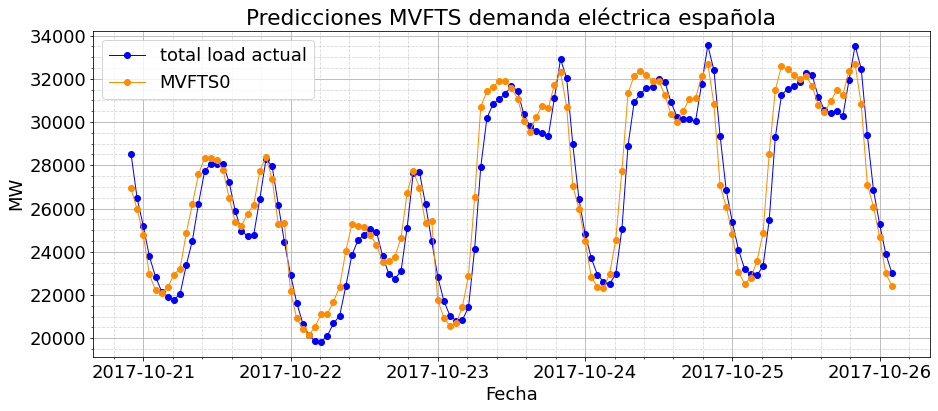

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'MVFTS0']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='MVFTS_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones MVFTS demanda eléctrica española')

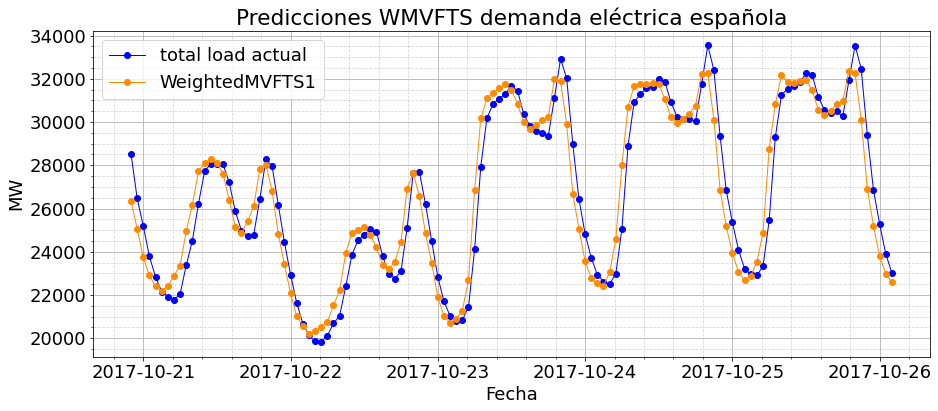

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'WeightedMVFTS1']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='WMVFTS_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones WMVFTS demanda eléctrica española')

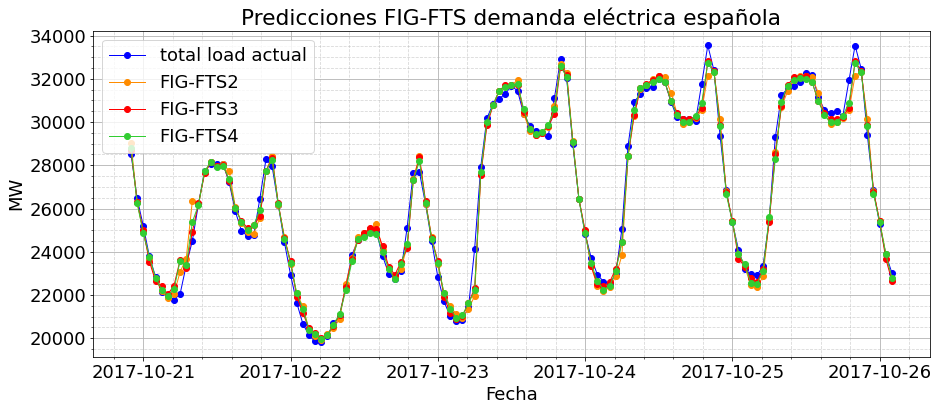

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'FIG-FTS2', 'FIG-FTS3', 'FIG-FTS4']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='FIGFTS_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones FIG-FTS demanda eléctrica española')

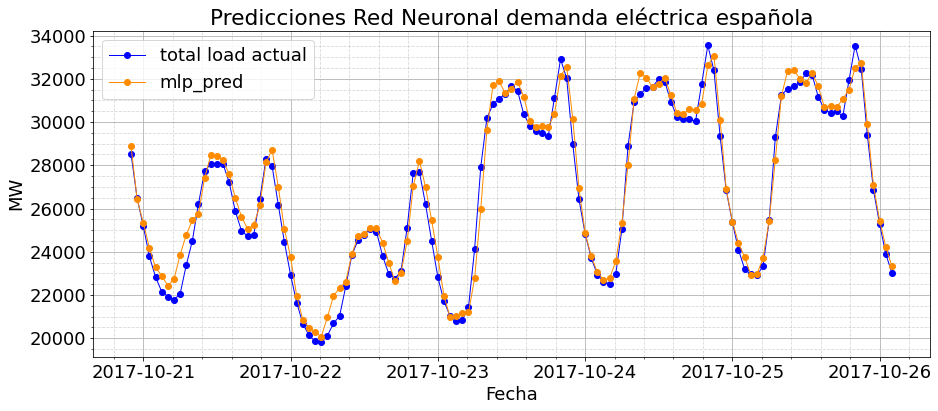

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'mlp_pred']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='MLP_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones Red Neuronal demanda eléctrica española')

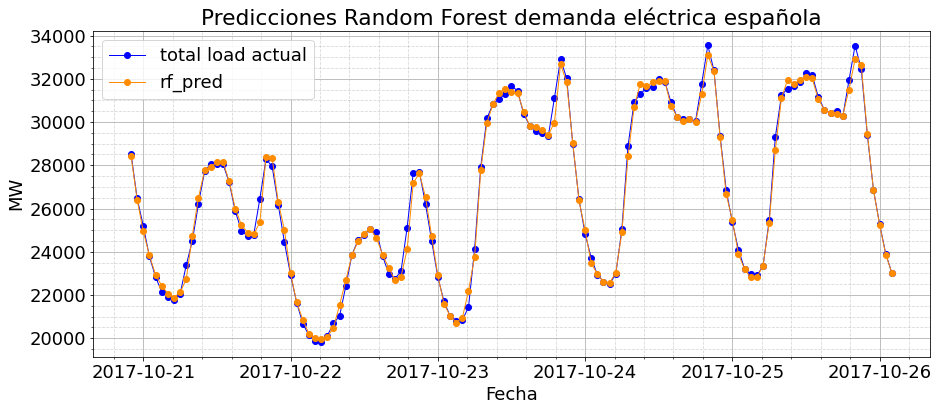

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'rf_pred']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='RF_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones Random Forest demanda eléctrica española')

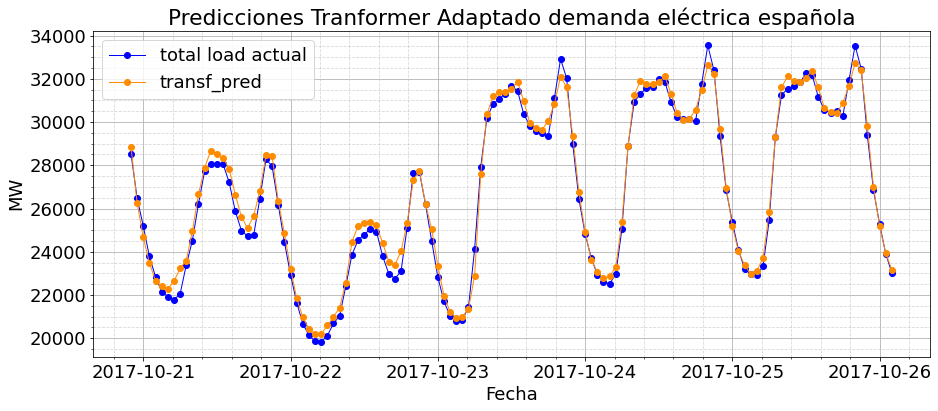

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'transf_pred']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='TRANSF_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones Tranformer Adaptado demanda eléctrica española')

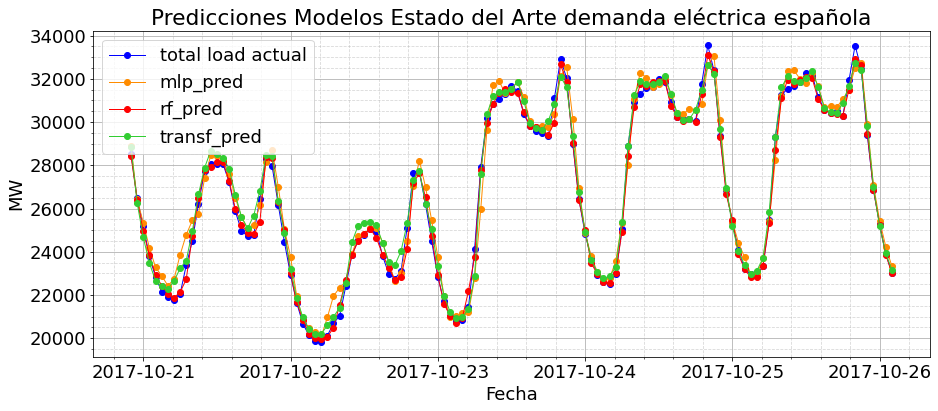

In [ ]:
df = df_predictions.iloc[:125]
columns_to_plot = ['total load actual', 'mlp_pred', 'rf_pred', 'transf_pred']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='STATE_ART_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones Modelos Estado del Arte demanda eléctrica española')

### Pronóstico extendido

Dada la variedad de modelos, se realizó este proceso para los modelos de estado del arte y 2 modelos difusos multivariables, los cuales fueron el PWFTS, el random forest y el transformer adaptado. Estas se realizaron tomando los 72 primeros valores de los datos de prueba, para la obtención de un prónostico sobre las siguientes 48 horas.

In [ ]:
training_length = 72
forecast_window = 48

df_to_forecast_extended = test_df.iloc[:(training_length + forecast_window)]
# df_to_forecast_extended

#### Pronóstico extendido para modelos de ML supervisado

Se diseño la siguiente función para realizar predicciones sobre grandes intervalos de pérdida de datos de modelos de ML tradicionales.

In [ ]:
def forecast_extended(data, model, forecast_window):
  predictions = np.array([])
  serie_k = data
  # serie_k = data
  # print(serie_k.__len__())
  for k in range(forecast_window):
    serie_k = serie_k.reshape(1,-1)
    prediction = model.predict(serie_k)
    serie_k = np.delete(serie_k, 0)
    serie_k = np.append(serie_k, prediction)
    predictions = np.append(predictions, prediction)

  return predictions

In [ ]:
# Separación de datos en conjuntos de entrenamiento y validación.
train_size = .7
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_size, shuffle=False)

# Configuración de regresores (sin tuneo) Red Neuronal y Random Forest.
mlp_regressor = MLPRegressor(hidden_layer_sizes=100, activation='relu')
rf_regressor = RandomForestRegressor(n_estimators=150)

# Entrenamiento de los modelos clásicos
mlp_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150)

In [ ]:
model = rf_regressor
data = X_test.iloc[1].values

predictions_extended_ml = forecast_extended(data=data, model=model, forecast_window=forecast_window)

# y_extended_test = y_test.iloc[:forecast_window].values
# predictions_extended_2 = np.c_[y_extended_test, predictions_extended]

# df_predictions_extended = pd.DataFrame(predictions_extended_2, columns=['y', 'prediction'])
# df_predictions_extended.plot(grid=True, figsize=(12,7))

#### Pronóstico extendido para transformer adaptado

In [ ]:
def inference_multi_steps(df, model, device, training_length, forecast_window):

  df_process = df.copy()
  df_process = df_date_encoding(df_process)
  scaler = load('scalar_item.joblib')
  demand_original = df_process['total load actual'].values
  df_process['total load actual'] = scaler.transform(demand_original.reshape(-1,1))[:,0]
  dataset = DemandDataset(df_process, training_length=training_length, forecast_window=forecast_window, scale=False)
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  # print(dataloader)

  with torch.no_grad():

    model.eval()
    # print(dataloader)
    for index_in, index_tar, _input, target in dataloader:
      src = _input.permute(1,0,2).double().to(device)[1:, :, :]
      target = target.permute(1,0,2).double().to(device)

      next_input_model = src
      all_predictions = []

      for i in range(forecast_window - 1):
        prediction = model(next_input_model, device)

        if all_predictions == []:
          all_predictions = prediction # 47,1,1: t2' - t48'
        else:
          all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0))) # 47+,1,1: t2' - t48', t49', t50'
        
        pos_encoding_old_vals = src[i+1:, :, 1:] # 46, 1, 6, pop positional encoding first value: t2 -- t47
        pos_encoding_new_val = target[i + 1, :, 1:].unsqueeze(1) # 1, 1, 6, append positional encoding of last predicted value: t48
        pos_encodings = torch.cat((pos_encoding_old_vals, pos_encoding_new_val)) # 47, 1, 6 positional encodings matched with prediction: t2 -- t48

        next_input_model = torch.cat((src[i+1:, :, 0].unsqueeze(-1), prediction[-1,:,:].unsqueeze(0))) #t2 -- t47, t48'
        next_input_model = torch.cat((next_input_model, pos_encodings), dim = 2) # 47, 1, 7 input for next round

    output = scaler.inverse_transform(all_predictions[:,:,0].detach().cpu().numpy())

  return np.array(output).reshape(-1,).astype(np.float64)

In [ ]:
# Model hyperparameters
n_heads = 7
encoder_layers = 2
dim_ff_enc = 2048

device = "cpu"
method = 'sampling'

epochs = 500

train_dataset = DemandDataset(df=df_energy_train, training_length=training_length, forecast_window = forecast_window)
test_dataset = DemandDataset(df=df_energy_test, training_length=training_length, forecast_window = forecast_window)

feature_size = train_dataset.__getitem__(0)[2].size()[1]

best_model = main(train_dataset, test_dataset, model_features=feature_size, model_heads=n_heads, model_dim_ff=dim_ff_enc, 
                  model_encoder_layers=encoder_layers, train_method=method, epoch=epochs, training_length=training_length, 
                  forecast_window=forecast_window, device=device)

[2022-04-05 01:42:18] [INFO] __main__ Epoch: 0, Training loss: 0.29956545086978514
[2022-04-05 01:42:20] [INFO] __main__ Epoch: 10, Training loss: 0.10067837161485434
[2022-04-05 01:42:23] [INFO] __main__ Epoch: 20, Training loss: 0.09439813194756112
[2022-04-05 01:42:26] [INFO] __main__ Epoch: 30, Training loss: 0.06233400625611266
[2022-04-05 01:42:28] [INFO] __main__ Epoch: 40, Training loss: 0.06135245633737326
[2022-04-05 01:42:31] [INFO] __main__ Epoch: 50, Training loss: 0.045462572950667655
[2022-04-05 01:42:33] [INFO] __main__ Epoch: 60, Training loss: 0.040650657075794405
[2022-04-05 01:42:35] [INFO] __main__ Epoch: 70, Training loss: 0.023739846567935166
[2022-04-05 01:42:38] [INFO] __main__ Epoch: 80, Training loss: 0.015940199009238442
[2022-04-05 01:42:40] [INFO] __main__ Epoch: 90, Training loss: 0.017955455906846954
[2022-04-05 01:42:42] [INFO] __main__ Epoch: 100, Training loss: 0.03232752896594004
[2022-04-05 01:42:44] [INFO] __main__ Epoch: 110, Training loss: 0.0237

In [ ]:
device = 'cpu'

path_to_save_model = "save_model/"
# path_to_save_model = directory_var
# best_model = 'best_train_5719.pth'

model = Transformer(feature_size=feature_size, n_heads=n_heads, dim_ff_enc=dim_ff_enc, num_layers=encoder_layers).double().to(device)
model.load_state_dict(torch.load(path_to_save_model+best_model, map_location=torch.device(device)))

df = df_to_forecast_extended

predictions_extended = inference_multi_steps(df=df, model=model, device=device, training_length=training_length, 
                                             forecast_window=forecast_window)

predictions_extended_transformer = predictions_extended[-forecast_window:]

#### Pronostico extendido para modelos difusos

Desarrollo de los pronósticos extendidos para los modelos difusos, debido a que estas funcionalidades estan bien desarrolladas en la librería pyFTS el desarrollo es rápido.

In [ ]:
generator = lambda x : x + pd.to_timedelta(1, unit='h')

model_name = 'MVFTS0'
model = Util.load_obj(directory_var + model_name)

forecast_fuzzy_extended_1 = model.predict(test_df[71:72], steps_ahead=48, generators={'time':generator})


model_name = 'WeightedMVFTS1'
model = Util.load_obj(directory_var + model_name)

forecast_fuzzy_extended_2 = model.predict(test_df[71:72], steps_ahead=48, generators={'time':generator})

### Resultados sobre series determinadas y visualización gráfica.

Juntando en un dataframe las predicciones obtenidas anteriormente se analiza su rendimiento y se obtiene también su comportamiento.

In [ ]:
df_forecast_extended = df_to_forecast_extended.iloc[-forecast_window:]
# data_true_forecast_extended.__len__()

df_forecast_extended['rf_pred'] = predictions_extended_ml
df_forecast_extended['transf_pred'] = predictions_extended_transformer
df_forecast_extended['MVFTS'] = forecast_fuzzy_extended_1
df_forecast_extended['WMVFTS'] = forecast_fuzzy_extended_2

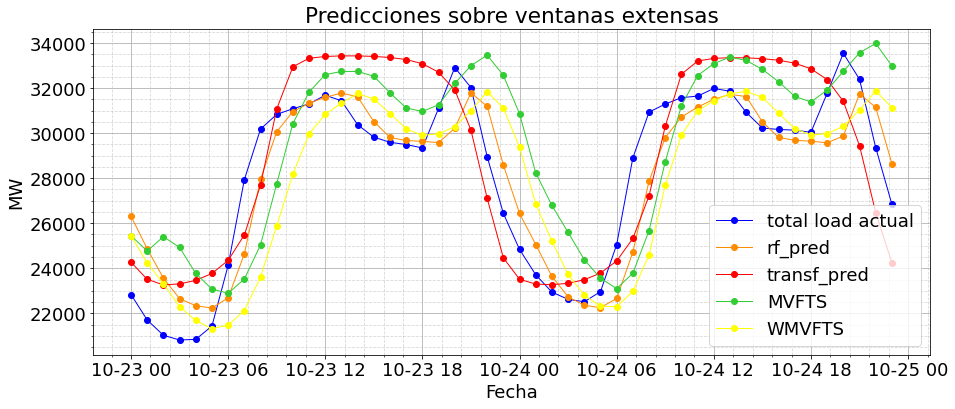

In [ ]:
df = df_forecast_extended
columns_to_plot = ['total load actual', 'rf_pred', 'transf_pred', 'MVFTS', 'WMVFTS']

visual_predictions(df=df, columns_to_plot=columns_to_plot, filename_save='TRANSF_predictions.png', xlabel='Fecha', ylabel='MW', 
                   title='Predicciones sobre ventanas extensas')

In [ ]:
regression_evaluation(df_forecast_extended, 'total load actual').sort_values('MAPE')

,model,RMSE,MAPE
0,rf_pred,1722.945354,4.866859
1,transf_pred,2258.631571,7.154100
3,WMVFTS,2768.854487,7.732455
2,MVFTS,3030.538051,9.396961
